ElectricityMaps data:


,zone,carbon_g_per_kwh,renewable_share_pct
0,US-CAL-CISO,320,38
1,US-NW-BPAT,122,90
2,US-SW-AZPS,594,13
3,US-CAL-BANC,248,67



Expanded to counties (multi-zone):


,county,zone,carbon_g_per_kwh,renewable_share_pct
0,Los Angeles,US-CAL-CISO,320,38
1,Orange,US-CAL-CISO,320,38
2,San Diego,US-CAL-CISO,320,38
3,Riverside,US-CAL-CISO,320,38
4,San Francisco,US-NW-BPAT,122,90



Scored counties:


,county,zone,carbon_g_per_kwh,renewable_share_pct,score
4,San Francisco,US-NW-BPAT,122,90,100.000000
5,Humboldt,US-NW-BPAT,122,90,100.000000
6,Mendocino,US-NW-BPAT,122,90,100.000000
16,Santa Clara,US-CAL-BANC,248,67,71.717477
15,San Mateo,US-CAL-BANC,248,67,71.717477
14,Alameda,US-CAL-BANC,248,67,71.717477
13,Sacramento,US-CAL-BANC,248,67,71.717477
1,Orange,US-CAL-CISO,320,38,45.259190
0,Los Angeles,US-CAL-CISO,320,38,45.259190
3,Riverside,US-CAL-CISO,320,38,45.259190


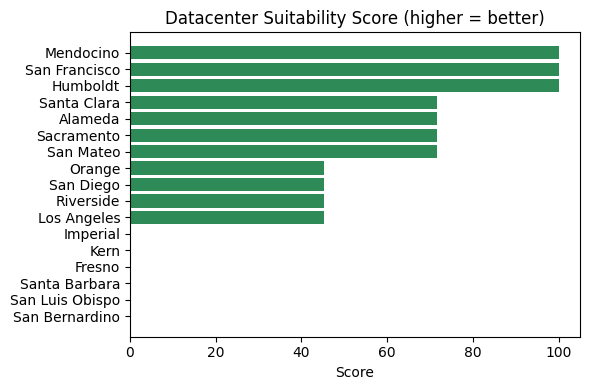

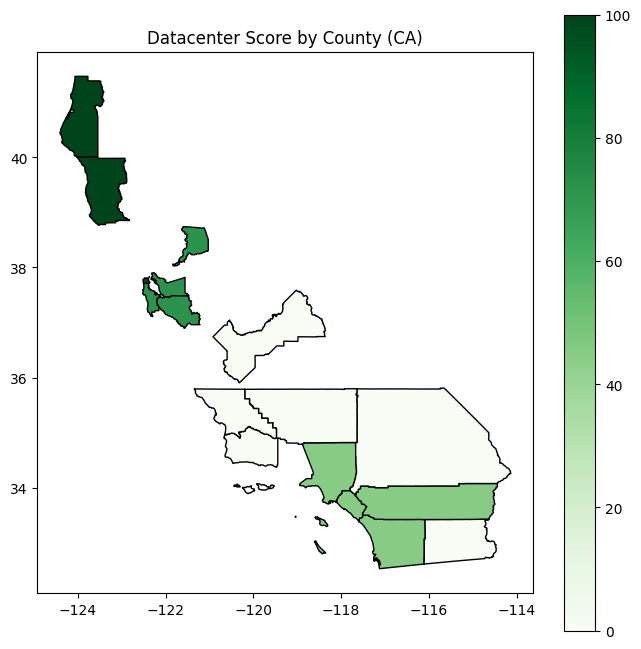

In [7]:
# --------------------
# 1️⃣ Setup
# --------------------
import os, requests, pandas as pd, numpy as np
from dotenv import load_dotenv
import matplotlib.pyplot as plt

load_dotenv()   # reads your .env file if present

API_KEY = os.getenv("EMAPS_API_KEY")
BASE_URL = "https://api.electricitymaps.com/v3"

if not API_KEY:
    raise ValueError("⚠️ No API key found. Put it in a .env file as EMAPS_API_KEY=...")

# ElectricityMaps uses 'auth-token' header (not Bearer)
headers = {"auth-token": API_KEY}


# --------------------
# 2️⃣ Fetch live data from ElectricityMaps
# --------------------
def fetch_emaps(zone="US-CAL-CISO"):
    """Fetch carbon intensity (gCO2eq/kWh) and renewable share (%) for one zone."""
    # ---- Carbon intensity ----
    ci_resp = requests.get(
        f"{BASE_URL}/carbon-intensity/latest",
        headers=headers,
        params={"zone": zone},
        timeout=30
    )
    ci_resp.raise_for_status()
    ci = ci_resp.json()
    carbon = ci.get("carbonIntensity", np.nan)

    # ---- Power breakdown ----
    mix_resp = requests.get(
        f"{BASE_URL}/power-breakdown/latest",
        headers=headers,
        params={"zone": zone},
        timeout=30
    )
    mix_resp.raise_for_status()
    mix = mix_resp.json()

    # Prefer the explicit renewablePercentage if present
    if "renewablePercentage" in mix:
        renew_share = mix["renewablePercentage"]
    elif "powerConsumptionBreakdown" in mix:
        cons = mix["powerConsumptionBreakdown"]
        renew_keys = {"solar","wind","hydro","geothermal","biomass"}
        total = sum(v for v in cons.values() if isinstance(v, (int,float))) or 1e-9
        renew = sum(v for k,v in cons.items() if k.lower() in renew_keys and isinstance(v,(int,float)))
        renew_share = 100 * renew / total
    else:
        renew_share = np.nan
        print(f"⚠️ No renewable data available for {zone}")

    return {
        "zone": zone,
        "carbon_g_per_kwh": carbon,
        "renewable_share_pct": renew_share
    }


# ✅ Only US-CAL-CISO is valid for ElectricityMaps
zones = ["US-CAL-CISO", "US-NW-BPAT", "US-SW-AZPS", "US-CAL-BANC"]
records = [fetch_emaps(z) for z in zones]
df_zones = pd.DataFrame(records)
print("ElectricityMaps data:")
display(df_zones)


# --------------------
# 3️⃣ Map each zone → counties
# --------------------
ZONE_TO_COUNTIES = {
    "US-CAL-CISO": ["Los Angeles","Orange","San Diego","Riverside"],
    "US-CAL-BANC": ["Sacramento","Alameda","San Mateo","Santa Clara"],
    "US-NW-BPAT": ["San Francisco","Humboldt","Mendocino"],
    "US-SW-AZPS": ["Imperial","San Bernardino","Kern","Fresno","Santa Barbara","San Luis Obispo"]
}

rows = []
for _, row in df_zones.iterrows():
    zone = row["zone"]
    for county in ZONE_TO_COUNTIES.get(zone, []):
        rows.append({
            "county": county,
            "zone": zone,
            "carbon_g_per_kwh": row["carbon_g_per_kwh"],
            "renewable_share_pct": row["renewable_share_pct"]
        })

df = pd.DataFrame(rows)
print("\nExpanded to counties (multi-zone):")
display(df.head())



# --------------------
# 4️⃣ Compute Datacenter Score
# --------------------
def normalize_metric(x, higher_is_better=True):
    """Z-score → minmax normalize (0–1)."""
    z = (x - x.mean()) / (x.std() or 1e-9)
    mm = (z - z.min()) / ((z.max() - z.min()) or 1e-9)
    return mm if higher_is_better else (1 - mm)

df["score"] = (
    0.5 * normalize_metric(df["renewable_share_pct"], True)
  + 0.5 * normalize_metric(df["carbon_g_per_kwh"], False)
) * 100

print("\nScored counties:")
display(df.sort_values("score", ascending=False))


# --------------------
# 5️⃣ Quick visualization
# --------------------
df_plot = df.sort_values("score", ascending=True)
plt.figure(figsize=(6,4))
plt.barh(df_plot["county"], df_plot["score"], color="seagreen")
plt.title("Datacenter Suitability Score (higher = better)")
plt.xlabel("Score")
plt.tight_layout()
plt.show()


# --------------------
# 6️⃣ (Optional) Choropleth if GeoPandas is installed
# --------------------
try:
    import geopandas as gpd
    CA_GEOJSON = "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/california-counties.geojson"
    gdf = gpd.read_file(CA_GEOJSON)
    gdf = gdf.merge(df, left_on="name", right_on="county", how="left")

    gdf.plot(column="score", cmap="Greens", legend=True, edgecolor="black", figsize=(8,8))
    plt.title("Datacenter Score by County (CA)")
    plt.show()
except Exception as e:
    print("⚠️ GeoPandas not installed or map fetch failed:", e)
